Downloading the trial records from OldBailey using the API

In [ ]:
import requests
import os
import time
from google.colab import drive

#store text files
save_path = '/content/oldbailey'
os.makedirs(save_path, exist_ok=True)

# API endpoints
SEARCH_API = "https://www.dhi.ac.uk/api/data/oldbailey_record"
SINGLE_RECORD_API = "https://www.dhi.ac.uk/api/data/oldbailey_record_single"

#parameters
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept': 'application/json'
}

def get_sample_ids(total_records=20):
    """Retrieve trial record IDs (starting with 't') from the API with pagination"""
    print("Fetching trial record IDs...")
    all_ids = []
    page_size = 10
    current_from = 0

    while len(all_ids) < total_records:
        params = {
            'size': page_size,
            'from': current_from,
            'text': '*'
        }

        response = requests.get(SEARCH_API, params=params, headers=headers)

        if response.status_code != 200:
            print(f"Error fetching IDs: {response.status_code}")
            break

        data = response.json()
        hits = data['hits']['hits']

        if not hits:
            break  # No more records

        # Extract only trial IDs (starting with 't') from current page
        page_ids = [
            hit['_source']['idkey']
            for hit in hits
            if hit['_source']['idkey'].startswith('t')
        ]
        all_ids.extend(page_ids)

        # Update pagination parameters
        current_from += page_size

        # Check if we've reached the requested total
        remaining = total_records - len(all_ids)
        if remaining <= 0:
            break

        # Adjust page size for final request if needed
        if remaining < page_size:
            page_size = remaining

        time.sleep(1)

    return all_ids[:total_records]  # Return exactly requested number

def save_records(record_ids):
    """Save individual records as xml files"""
    for i, record_id in enumerate(record_ids, 1):
        print(f"Downloading record {i}: {record_id}")
        params = {'idkey': record_id}

        try:
            response = requests.get(SINGLE_RECORD_API, params=params, headers=headers)
            if response.status_code == 200:
                data = response.json()
                text_content = data['hits']['hits'][0]['_source']['xml']

                # Clean filename and save
                safe_id = record_id.replace('/', '_')
                filename = os.path.join(save_path, f"{safe_id}.xml")
                with open(filename, 'w', encoding='utf-8') as f:
                    f.write(text_content)
                print(f"Successfully saved: {filename}")
            else:
                print(f"Failed to download {record_id} (Status: {response.status_code})")

            # Short pause between requests
            time.sleep(1)

        except Exception as e:
            print(f"Error processing {record_id}: {str(e)}")

#execution
sample_ids = get_sample_ids(40)  # Request number of trial records

if sample_ids:
    # print("\nFound these trial records:")
    # for id in sample_ids:
    #     print(f"- {id}")

    save_records(sample_ids)

    # # Optional: Save to Google Drive
    # drive.mount('/content/drive')
    # !cp -r {save_path} "/content/drive/MyDrive/"
    # print("\nFiles copied to Google Drive!")
else:
    print("No trial records found to download")

Fetching trial record IDs...
Successfully saved: /content/oldbailey/t16740429-1.xml
Successfully saved: /content/oldbailey/t16740429-2.xml
Successfully saved: /content/oldbailey/t16740429-3.xml
Successfully saved: /content/oldbailey/t16740429-4.xml
Successfully saved: /content/oldbailey/t16740429-5.xml
Successfully saved: /content/oldbailey/t16740429-6.xml
Successfully saved: /content/oldbailey/t16740429-7.xml
Successfully saved: /content/oldbailey/t16740429-8.xml
Successfully saved: /content/oldbailey/t16740429-9.xml
Successfully saved: /content/oldbailey/t16740717-1.xml
Successfully saved: /content/oldbailey/t16740717-2.xml
Successfully saved: /content/oldbailey/t16740717-3.xml
Successfully saved: /content/oldbailey/t16740717-4.xml
Successfully saved: /content/oldbailey/t16740717-5.xml
Successfully saved: /content/oldbailey/t16740717-6.xml
Successfully saved: /content/oldbailey/t16740909-1.xml
Successfully saved: /content/oldbailey/t16740909-2.xml
Successfully saved: /content/oldbail

**Sample inputs for 1 trial, 1 day, 1 month**

In [ ]:

# Input for one trial
one_trial = ['/content/oldbailey/t16740429-7.xml']

# Input for one day (all trials on July 17, 1674)
one_day = [
    '/content/oldbailey/t16740717-1.xml',
    '/content/oldbailey/t16740717-2.xml',
    '/content/oldbailey/t16740717-3.xml',
    '/content/oldbailey/t16740717-4.xml',
    '/content/oldbailey/t16740717-5.xml',
    '/content/oldbailey/t16740717-6.xml'
]

# Input for one month (all trials in April 1674)
one_month = [
    '/content/oldbailey/t16740429-1.xml',
    '/content/oldbailey/t16740429-2.xml',
    '/content/oldbailey/t16740429-3.xml',
    '/content/oldbailey/t16740429-4.xml',
    '/content/oldbailey/t16740429-5.xml',
    '/content/oldbailey/t16740429-6.xml',
    '/content/oldbailey/t16740429-7.xml',
    '/content/oldbailey/t16740429-8.xml',
    '/content/oldbailey/t16740429-9.xml'
]

Parse the XML files

In [ ]:
import os
import re
import xml.etree.ElementTree as ET
import time

def parse_trial(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    trial_data = {
        "defendants": [],
        "verdicts": []
    }

    defendant_genders = {}
    for pers in root.findall(".//persName[@type='defendantName']"):
        defendant_id = pers.get("id")  # Get the defendant's ID
        gender = pers.find("interp[@type='gender']")
        gender_value = gender.get("value") if gender is not None else "unknown"
        trial_data["defendants"].append(gender_value)
        defendant_genders[defendant_id] = gender_value

    # Extract guilty verdicts and associate them with defendant genders
    for verdict in root.findall(".//rs[@type='verdictDescription']"):
        if verdict.find("interp[@type='verdictCategory']").get("value") == "guilty":
            verdict_id = verdict.get("id")  # Get the verdict ID
            # Find the corresponding <join> element for this verdict
            for join_element in root.findall(".//join[@result='criminalCharge']"):
                targets = join_element.get("targets").split()
                if verdict_id in targets:

                    for target in targets:
                        if "defend" in target:  # Find the defendant ID in the targets
                            defendant_id = target
                            if defendant_id in defendant_genders:
                                trial_data["verdicts"].append(defendant_genders[defendant_id])

    return trial_data

Using Counter()  to count frequencies




In [ ]:
from collections import Counter

def count_frequencies_counter(trial_files):
    # Initialize counters
    all_defendants = []
    all_verdicts = []

    for file in trial_files:
        data = parse_trial(file)
        all_defendants.extend(data["defendants"])
        all_verdicts.extend(data["verdicts"])

    # Use Counter to count frequencies
    defendant_counter = Counter(all_defendants)
    verdict_counter = Counter(all_verdicts)

    # Format the results similar to the other functions
    defendant_counts = {
        "total": len(all_defendants),
        "male": defendant_counter["male"],
        "female": defendant_counter["female"]
    }

    verdict_counts = {
        "total": len(all_verdicts),
        "male": verdict_counter["male"],
        "female": verdict_counter["female"]
    }

    return defendant_counts, verdict_counts

Using Pandas to count frequencies

In [ ]:
import pandas as pd

def count_frequencies_pandas(trial_files):
    # Lists to store all data
    all_data = {"defendants": [], "verdicts": []}

    for file in trial_files:
        data = parse_trial(file)
        all_data["defendants"].extend(data["defendants"])
        all_data["verdicts"].extend(data["verdicts"])

    # Convert to pandas DataFrame
    df_defendants = pd.DataFrame(all_data["defendants"], columns=["gender"])
    df_verdicts = pd.DataFrame(all_data["verdicts"], columns=["gender"])

    # Count frequencies
    defendant_counts = {
        "total": len(df_defendants),
        "male": len(df_defendants[df_defendants["gender"] == "male"]),
        "female": len(df_defendants[df_defendants["gender"] == "female"])
    }

    verdict_counts = {
        "total": len(df_verdicts),
        "male": len(df_verdicts[df_verdicts["gender"] == "male"]),
        "female": len(df_verdicts[df_verdicts["gender"] == "female"])
    }

    # #using value_counts() [MUCH FASTER]
    # defendant_counts = df_defendants["gender"].value_counts()
    # verdict_counts = df_verdicts["gender"].value_counts()


    return defendant_counts, verdict_counts

Run the counter and visualize the runtime

In [ ]:
inputs = [one_trial, one_day, one_month]

for input in inputs:
    print("Input:", (input))

    # Timing the Counter-based approach
    start_time_counter = time.time()
    defendant_counts_counter, verdict_counts_counter = count_frequencies_counter(input)
    time_counter = time.time() - start_time_counter

    # Timing the pandas-based approach
    start_time_pandas = time.time()
    defendant_counts_pandas, verdict_counts_pandas = count_frequencies_pandas(input)
    time_pandas = time.time() - start_time_pandas

    print("\nDefendant counts (Counter):", defendant_counts_counter)
    print("Verdict counts (Counter):", verdict_counts_counter)
    print("Execution time (Counter):", time_counter, "seconds")

    print("\nDefendant counts (pandas):", defendant_counts_pandas)
    print("Verdict counts (pandas):", verdict_counts_pandas)
    print("Execution time (pandas):", time_pandas, "seconds")
    print("\n")

Input: ['/content/oldbailey/t16740429-7.xml']

Defendant counts (Counter): {'total': 2, 'male': 2, 'female': 0}
Verdict counts (Counter): {'total': 2, 'male': 2, 'female': 0}
Execution time (Counter): 0.0004246234893798828 seconds

Defendant counts (pandas): {'total': 2, 'male': 2, 'female': 0}
Verdict counts (pandas): {'total': 2, 'male': 2, 'female': 0}
Execution time (pandas): 0.0038001537322998047 seconds


Input: ['/content/oldbailey/t16740717-1.xml', '/content/oldbailey/t16740717-2.xml', '/content/oldbailey/t16740717-3.xml', '/content/oldbailey/t16740717-4.xml', '/content/oldbailey/t16740717-5.xml', '/content/oldbailey/t16740717-6.xml']

Defendant counts (Counter): {'total': 6, 'male': 5, 'female': 1}
Verdict counts (Counter): {'total': 5, 'male': 4, 'female': 1}
Execution time (Counter): 0.0026443004608154297 seconds

Defendant counts (pandas): {'total': 6, 'male': 5, 'female': 1}
Verdict counts (pandas): {'total': 5, 'male': 4, 'female': 1}
Execution time (pandas): 0.0051233768

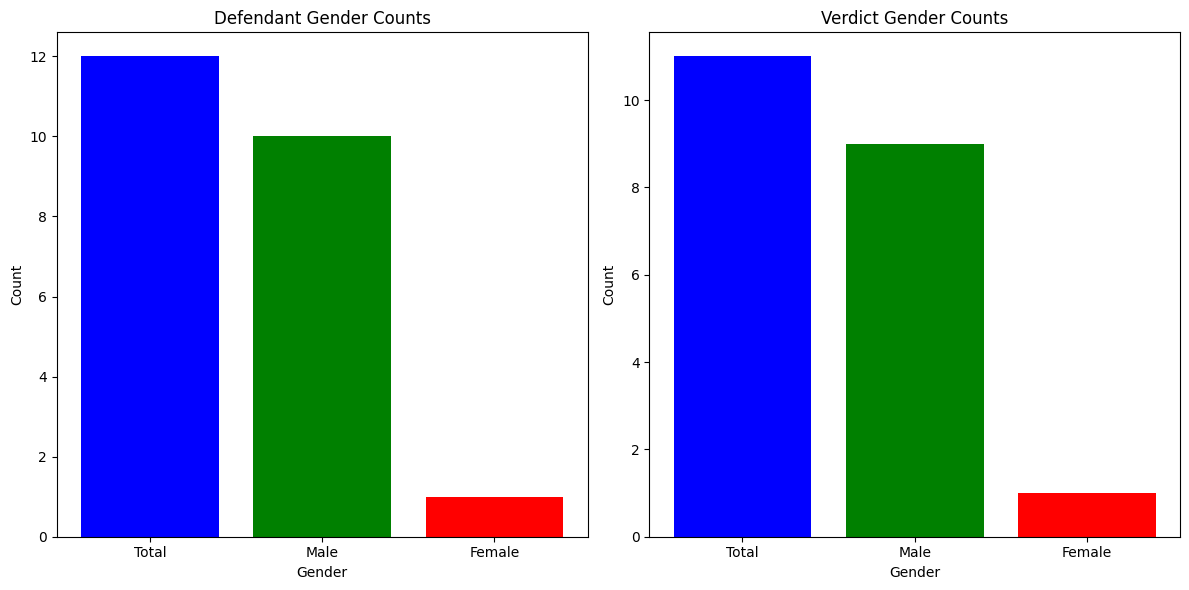

In [17]:
import matplotlib.pyplot as plt

def plot_gender_counts(defendant_counts, verdict_counts):
    labels = ["Total", "Male", "Female"]

    #one for defendants and one for verdicts
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    #Defendants
    axes[0].bar(labels, [defendant_counts["total"], defendant_counts["male"], defendant_counts["female"]], color=['blue', 'green', 'red'])
    axes[0].set_title('Defendant Gender Counts')
    axes[0].set_xlabel('Gender')
    axes[0].set_ylabel('Count')

    #Verdicts
    axes[1].bar(labels, [verdict_counts["total"], verdict_counts["male"], verdict_counts["female"]], color=['blue', 'green', 'red'])
    axes[1].set_title('Verdict Gender Counts')
    axes[1].set_xlabel('Gender')
    axes[1].set_ylabel('Count')

    plt.tight_layout()

    plt.show()
defendant_counts, verdict_counts = count_frequencies_pandas(one_month)
plot_gender_counts(defendant_counts, verdict_counts)